In [1]:
import datautil
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm
import matplotlib.patheffects as path_effects
import networkx as nx
import seaborn as sns
from collections import Counter, defaultdict

In [2]:
projects, libraries, migrations, rules, dep_changes = datautil.get_data()

print(f"{len(set(migrations.fromLib))} source libs, {len(set(migrations.toLib))} target libs, {len(set(migrations.fromLib) | set(migrations.toLib))} total libs")
print(f"{len(set(migrations.startCommit) | set(migrations.endCommit))} total commits")
print(f"{len(set(migrations.repoName))} repositories")
print(f"{len(set(zip(migrations.fromLib, migrations.toLib)))} migration rules")

390 source libs, 562 target libs, 716 total libs
3163 total commits
1601 repositories
1194 migration rules


In [3]:
print(len(set(dep_changes[dep_changes.lib1.isin(set(migrations.fromLib) | set(migrations.toLib))].project)))

9693


In [4]:
commits_rename, commits_nonrename = set(), set()
rule2type = pd.read_csv("data/rules_typed.csv")
rule2type = {(row.fromLib, row.toLib): row.type for idx, row in rule2type.iterrows()}
for idx, row in migrations.iterrows():
    if rule2type[(row.fromLib, row.toLib)] == "undecided":
        commits_nonrename |= {row.startCommit, row.endCommit}
    else:
        commits_rename |= {row.startCommit, row.endCommit}
print(len(commits_rename), len(commits_nonrename), len(commits_rename - commits_nonrename))

1607 1704 1459


In [5]:
valid_projects = dep_changes[dep_changes.lib2.isin(set(migrations.fromLib))].project
projects = projects[projects.nameWithOwner.isin(valid_projects)]
dep_changes = dep_changes[dep_changes.project.isin(valid_projects)]
print(f"{len(projects)} projects, {len(dep_changes)} dep changes")

17681 projects, 2624947 dep changes


In [6]:
cls2 = pd.read_excel("data/cls2.xlsx")
lib2category = dict(zip(cls2.package, cls2.adjusted_category))
lib2popularity = dict(zip(libraries.name, libraries.addedProjects))

In [7]:
rules["fromLibCategory"] = rules.fromLib.map(lambda x: lib2category[x]).fillna("Other")
rules["toLibCategory"] = rules.toLib.map(lambda x: lib2category[x]).fillna("Other")
rules["numRepositories"] = [len(set(migrations[(migrations.fromLib == from_lib) & (migrations.toLib == to_lib)].repoName))
                            for from_lib, to_lib in zip(rules.fromLib, rules.toLib)]
rules["repos"] =  [set(migrations[(migrations.fromLib == from_lib) & (migrations.toLib == to_lib)].repoName)
                            for from_lib, to_lib in zip(rules.fromLib, rules.toLib)]
rules.head()

,fromLib,toLib,fromLibCategory,toLibCategory,numRepositories,repos
0,ant:ant,org.apache.ant:ant,Build,Build,15,"{Top-Q_jsystem, apache_cayenne, apache_axis2-j..."
1,ant:ant,org.apache.ant:ant-apache-regexp,Build,Build,1,{bobmcwhirter_drools}
2,ant:ant,org.apache.ant:ant-junit,Build,Build,1,{wocommunity_wolips}
3,ant:ant,org.apache.ant:ant-nodeps,Build,Build,3,"{bobmcwhirter_drools, SeleniumHQ_selenium, apa..."
4,ant:ant,org.apache.ant:ant-trax,Build,Build,1,{SeleniumHQ_selenium}


In [8]:
rules[rules.fromLibCategory != rules.toLibCategory]

,fromLib,toLib,fromLibCategory,toLibCategory,numRepositories,repos
53,ch.qos.logback:logback-classic,org.springframework.boot:spring-boot-dependencies,Logging,BOM,1,{hekate-io_hekate}
65,ch.qos.logback:logback-core,org.springframework.boot:spring-boot-dependencies,Logging,BOM,1,{hekate-io_hekate}
96,com.datastax.cassandra:cassandra-driver-core,org.hibernate:hibernate-search-engine,Database,Persistence,1,{hawkular_hawkular-alerts}
113,com.fasterxml.jackson.core:jackson-annotations,org.springframework.boot:spring-boot-dependencies,JSON,BOM,1,{hekate-io_hekate}
125,com.fasterxml.jackson.core:jackson-core,org.springframework.boot:spring-boot-dependencies,JSON,BOM,1,{hekate-io_hekate}
...,...,...,...,...,...,...
1343,org.springframework:spring-webmvc,org.springframework.boot:spring-boot-starter-t...,Webservice,Template,10,"{apache_logging-log4j-audit, xianrendzw_EasyRe..."
1363,org.xerial:sqlite-jdbc,javax.servlet:javax.servlet-api,Database,Webservice,1,{52North_SOS}
1378,rome:rome,jaxen:jaxen,RSS,XML,1,{spring-social_spring-social-google}
1379,rome:rome,org.apache.httpcomponents:httpclient,RSS,HTTP Clients,1,{igniterealtime_Openfire}


53 32
Counter({'Logging': 1261, 'JSON': 1024, 'Testing': 720, 'Webservice': 701, 'Other': 326, 'HTTP Clients': 135, 'XML': 128, 'Core Utilities': 112, 'Database': 110, 'Persistence': 108, 'I/O': 106, 'Bytecode': 68, 'Metrics': 66, 'Build': 62, 'Dependency Injection': 51, 'JDBC Pools': 51, 'Code Analyzers': 36, 'Mail': 36, 'Command Line': 31})


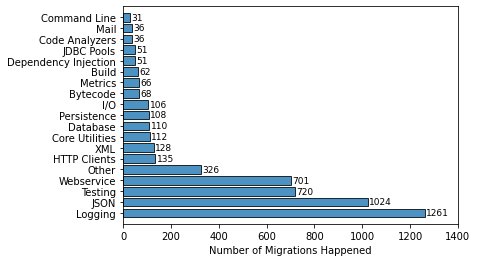

In [9]:
data = rules[rules.fromLibCategory == rules.toLibCategory]
catdis = Counter()
for x, y in zip(data.fromLibCategory, data.numRepositories):
    catdis[x] += y
#catdis = {x: len(y) for x, y in catdis.items()}
print(len(catdis), len([x for x in catdis if catdis[x] >= 10]))
for key in list(catdis.keys()):
    if key != "other" and catdis[key] < 30:
        catdis["Other"] += catdis[key]
        del catdis[key]
print(catdis)
data = sorted(catdis.items(), key=lambda x: -x[1])
fig, ax = plt.subplots(figsize=(6,4))
ax.barh(y=range(0, len(data)), width=[x[1] for x in data], tick_label=[x[0] for x in data], edgecolor="black", facecolor=sns.color_palette()[0], alpha=0.8)
for i in range(0, len(data)):
    ax.text(data[i][1]+5, i, str(data[i][1]), fontsize=9, horizontalalignment="left", verticalalignment="center")
ax.set_ylim(-1, len(data))
ax.set_xlim(0, 1400)
ax.set_xlabel("Number of Migrations Happened")
fig.savefig("plots/migrepodist.pdf", bbox_inches="tight")

53 16
Counter({'Webservice': 182, 'Logging': 161, 'JSON': 154, 'Testing': 152, 'Other': 140, 'XML': 42, 'Database': 36, 'Persistence': 31, 'Dependency Injection': 26, 'Bytecode': 26, 'HTTP Clients': 20, 'JDBC Pools': 19, 'Metrics': 19, 'Build': 14, 'Command Line': 13, 'Cache': 11, 'Tag': 10})


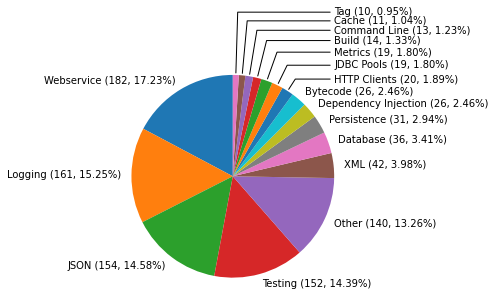

In [10]:
catdis = Counter(rules[rules.fromLibCategory == rules.toLibCategory].fromLibCategory)
print(len(catdis), len([x for x in catdis if catdis[x] >= 10]))
for key in list(catdis.keys()):
    if key != "other" and catdis[key] < 10:
        catdis["Other"] += catdis[key]
        del catdis[key]
print(catdis)
data = sorted(catdis.items(), key=lambda x: -x[1])
labels = [f"{x[0]} ({x[1]}, {100 * x[1] / sum(catdis.values()):.2f}%)" for x in data]
fig, ax = plt.subplots(figsize=(4,4))
patches, texts = ax.pie([x[1] for x in data], labels=labels[0:10] + [""] * (len(labels) - 10),
        shadow=False, startangle=90, labeldistance=1.1, pctdistance=0.8)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

kw = dict(arrowprops=dict(arrowstyle="-"), zorder=0, va="center")
for i in range(-7, 0):
    p = patches[i]
    ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(labels[i], xy=(x, y), xytext=(1*np.sign(x), (1.7 + 0.08 * i) *y),
                horizontalalignment=horizontalalignment, **kw)
fig.savefig("plots/migcat.pdf", bbox_inches="tight")

In [11]:
web_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "Webservice")]
print(f"{len(web_rules)} rules, {len(set(web_rules.fromLib) | set(web_rules.toLib))} libraries")

182 rules, 114 libraries


In [12]:
logging_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "Logging")]
print(f"{len(logging_rules)} rules, {len(set(logging_rules.fromLib) | set(logging_rules.toLib))} libraries")

161 rules, 35 libraries


In [13]:
json_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "JSON")]
print(f"{len(json_rules)} rules, {len(set(json_rules.fromLib) | set(json_rules.toLib))} libraries")

154 rules, 40 libraries


In [14]:
test_rules = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.fromLibCategory == "Testing")]
print(f"{len(test_rules)} rules, {len(set(test_rules.fromLib) | set(test_rules.toLib))} libraries")

152 rules, 73 libraries


All:     26.96% (193), 7.68% (55), 6.84% (49), 8.80% (63), 49.72% (356)
Logging: 14.29% (5), 5.71% (2), 25.71% (9), 25.71% (9), 28.57% (10)
JSON:    22.50% (9), 17.50% (7), 5.00% (2), 0.00% (0), 55.00% (22)
Web:     26.32% (30), 5.26% (6), 4.39% (5), 11.40% (13), 52.63% (60)
Test:    20.55% (15), 13.70% (10), 8.22% (6), 6.85% (5), 50.68% (37)


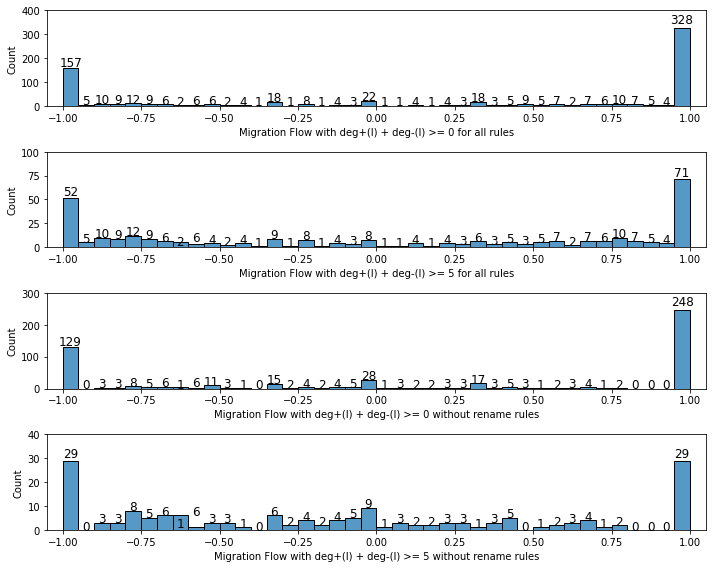

In [15]:
def get_migration_graph(subrules, rename="all", popthreshold=0):
    migration_graph = nx.DiGraph()
    #for lib in set(subrules.fromLib) | set(subrules.toLib):
        #if lib2popularity[lib] >= 100:
        #migration_graph.add_node(lib, pop=lib2popularity[lib])
    libs = set()
    for idx, rule in subrules.iterrows():
        if lib2popularity[rule.fromLib] >= popthreshold and lib2popularity[rule.toLib] >= popthreshold:
            if (rename == "all" or (rename == "rename" and "rename" in rule2type[(rule.fromLib, rule.toLib)])
                or (rename == "not" and "rename" not in rule2type[(rule.fromLib, rule.toLib)])):
                migration_graph.add_edge(rule.fromLib, rule.toLib, weight=rule.numRepositories)
                libs.add(rule.fromLib)
                libs.add(rule.toLib)
    for lib in libs:
        migration_graph.add_node(lib, pop=lib2popularity[lib])
    return migration_graph
def get_node_flows(migration_graph, threshold=0, rename=True):
    result = []
    for node in migration_graph.nodes():
        ind = migration_graph.in_degree(node, "weight")
        outd = migration_graph.out_degree(node, "weight")
        if (ind + outd >= threshold):
            result.append((ind - outd) / max(1, outd + ind))
    return result
def print_flow_dis(data):
    x1, x2, x3, x4, x5 = 0, 0, 0, 0, 0
    for i in data:
        if i <= -0.75:
            x1 += 1
        elif i <= -0.25:
            x2 += 1
        elif i <= 0.25:
            x3 += 1
        elif i < 0.75:
            x4 += 1
        else:
            x5 += 1
    y = sum([x1, x2, x3, x4, x5])
    print(f"{100 * x1 / y:.2f}% ({x1}), {100 * x2 / y:.2f}% ({x2}), {100 * x3 / y:.2f}% ({x3}), {100 * x4 / y:.2f}% ({x4}), {100 * x5 / y:.2f}% ({x5})")
logging_graph = get_migration_graph(logging_rules, rename="all")
json_graph = get_migration_graph(json_rules, rename="all")
web_graph = get_migration_graph(web_rules, rename="all")
test_graph = get_migration_graph(test_rules, rename="all")
all_graph = get_migration_graph(rules, rename="all")
print("All:     ", end="")
print_flow_dis(get_node_flows(all_graph))
print("Logging: ", end="")
print_flow_dis(get_node_flows(logging_graph))
print("JSON:    ", end="")
print_flow_dis(get_node_flows(json_graph))
print("Web:     ", end="")
print_flow_dis(get_node_flows(web_graph))
print("Test:    ", end="")
print_flow_dis(get_node_flows(test_graph))

fig, axes = plt.subplots(4, 1, figsize=(10, 8))

for i, t, ymax, rename in [(0, 0, 400, "all"), (1, 5, 100, "all"), (2, 0, 300, "not"), (3, 5, 40, "not")]:
    all_graph = get_migration_graph(rules, rename=rename)
    data = get_node_flows(all_graph, t)
    sns.histplot(data, binwidth=1/20, ax=axes[i])
    for j in range(-20, 20):
        count = len([x for x in data if x > j * 0.05 and x <= (j + 1) * 0.05])
        if j == -20: count += len([x for x in data if x == -1])
        axes[i].text(j * 0.05 + 0.025, count * 1.05, str(count), fontsize=12, horizontalalignment="center")
    axes[i].set_xlim(-1.05, 1.05)
    axes[i].set_ylim(0, ymax)
    if rename == "not":
        rename = "without rename"
    else:
        rename = "for all"
    axes[i].set_xlabel(f"Migration Flow with deg+(l) + deg-(l) >= {t} {rename} rules")

plt.tight_layout()
plt.savefig("plots/flow.pdf", bbox_inches="tight")

In [16]:
# Write the graph as JSON, for use in other programs
logging_graph = get_migration_graph(logging_rules, rename="all", popthreshold=100)
json_graph = get_migration_graph(json_rules, rename="all", popthreshold=100)
test_graph = get_migration_graph(test_rules, rename="all", popthreshold=100)
for name, g in [("logging", logging_graph), ("json", json_graph), ("test", test_graph)]:
    j = {"nodes": [], "edges": []}
    for n in g.nodes():
        ind = g.in_degree(n, "weight")
        outd = g.out_degree(n, "weight")
        flow = (ind - outd) / max(1, ind + outd)
        j["nodes"].append({"id": n, "flow": flow})
    for e in g.edges():
        j["edges"].append({"source": e[0], "target": e[1], "value": g.edges[e]["weight"]})
    with open(f"data/{name}.json", "w") as f:
        json.dump(j, f)
#print(logging_graph.edges())

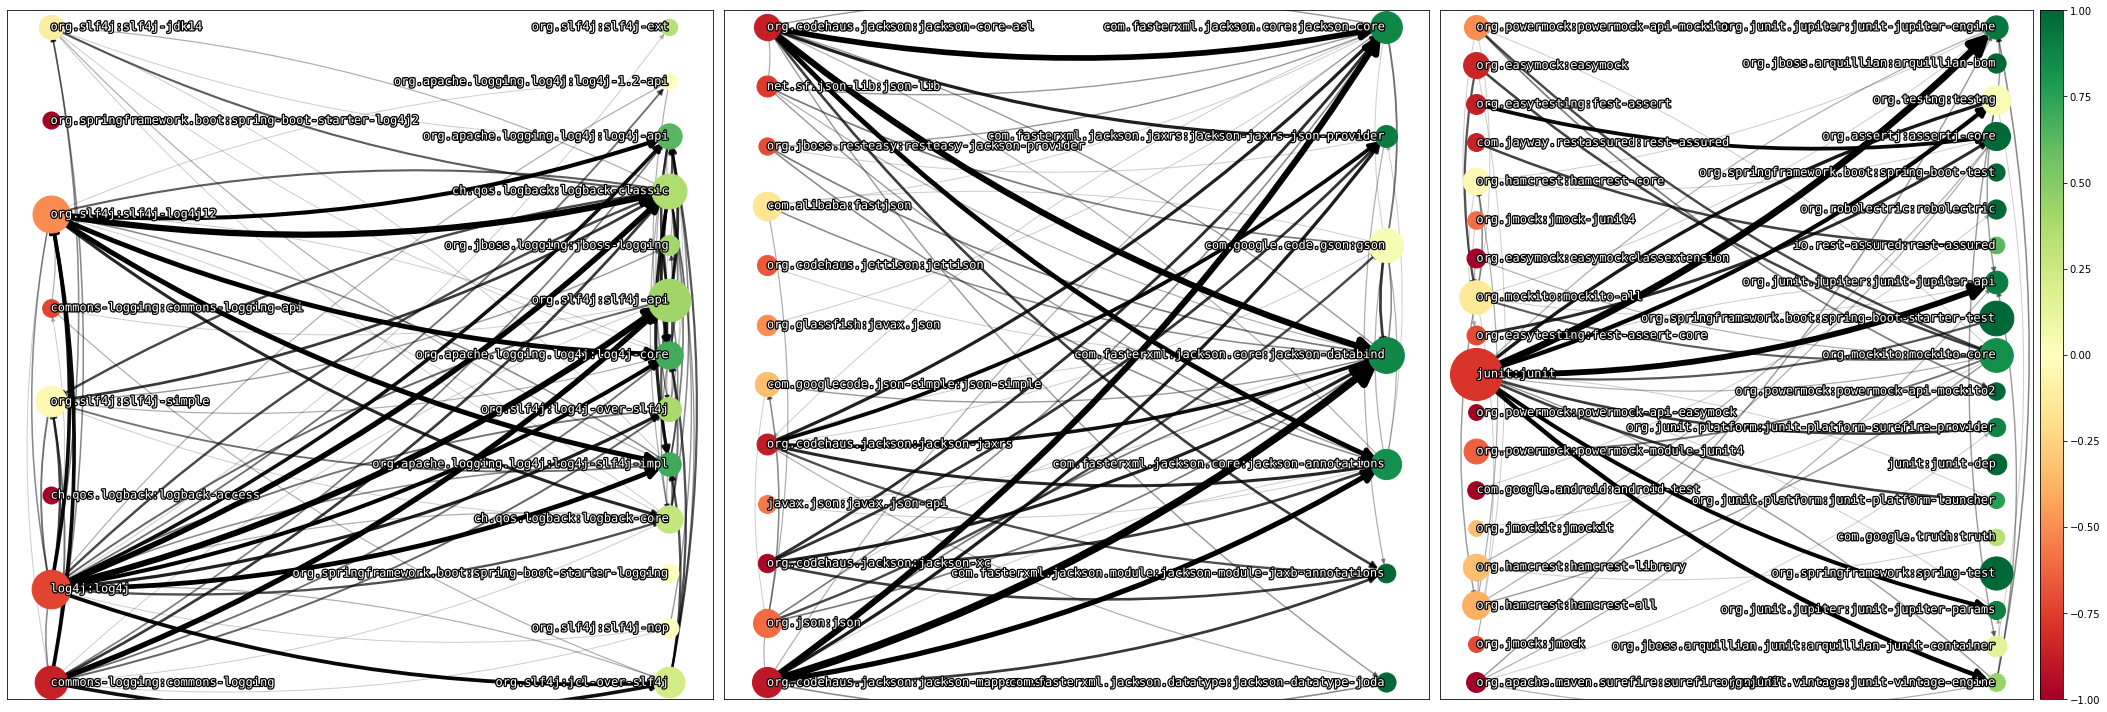

In [17]:
def visualize_migration_graph(migration_graph, ax, widthfactor=3):
    nodes = migration_graph.nodes()
    edges = migration_graph.edges()

    nodes_left = []
    for node in nodes:
        ind = migration_graph.in_degree(node, "weight")
        outd = migration_graph.out_degree(node, "weight")
        if ind < outd:
            nodes_left.append(node)
    pos = nx.bipartite_layout(migration_graph, nodes=nodes_left, aspect_ratio=0.5, scale=1, center=(0.0,0.0))
    #pos = nx.shell_layout(migration_graph)

    """
    for lib in pos:
        ind = migration_graph.in_degree(lib, "weight")
        outd = migration_graph.out_degree(lib, "weight")
        flow = (ind - outd) / max(1, ind + outd)
        offset = 0
        if abs(flow) < 0:
            offset = flow
        else:
            offset = -flow
        pos[lib][0] += flow
        #if lib in ["org.testng:testng", "com.google.code.gson:gson"]:
        #    pos[lib][0] += offset
        #if abs(flow) <= 0.8 and ("logback" in lib or "slf4j" in lib):
        #    pos[lib][0] += offset
    """
    
            
    label_pos_left, label_pos_right = dict(), dict()
    for node in nodes:
        if node in nodes_left:
            label_pos_left[node] = pos[node]
        else:
            label_pos_right[node] = pos[node]
            
    for i, edge in enumerate(edges):
        weight = migration_graph.edges[edge]["weight"]
        nx.draw_networkx_edges(migration_graph, pos, edgelist=[edge], ax=ax,
                           arrows=True, connectionstyle="arc3,rad=0.1",
                           width=widthfactor*np.sqrt(weight),
                           alpha=min(1.0,0.2*np.log2(weight)),
                           arrowsize=int(0.3*weight) + 10,
                           min_target_margin=migration_graph.nodes[edge[1]]["pop"] ** 0.25)
    for i, node in enumerate(nodes):
        ind = migration_graph.in_degree(node, "weight")
        outd = migration_graph.out_degree(node, "weight")
        nx.draw_networkx_nodes(migration_graph, pos, nodelist=[node], ax=ax,
                               node_size=25*np.sqrt(migration_graph.nodes[node]["pop"]),
                               node_color=(ind - outd) / max(1, outd + ind),
                               cmap="RdYlGn",
                               vmin=-1.0,
                               vmax=1.0)
    text_items = nx.draw_networkx_labels(migration_graph, pos=label_pos_left, labels={k:k for k in label_pos_left}, 
                                         ax=ax, font_size=12, font_family="monospace", font_color="white", 
                                         horizontalalignment="left")
    text_items.update(
        nx.draw_networkx_labels(migration_graph, pos=label_pos_right, labels={k:k for k in label_pos_right},
                                         ax=ax, font_size=12, font_family="monospace", font_color="white", 
                                         horizontalalignment="right"))
    for text in text_items.values():
        text.set_path_effects([path_effects.Stroke(linewidth=2.5, foreground='black'),
                       path_effects.Normal()])
        
    xmin, xmax = min(x[0] for x in pos.values()), max(x[0] for x in pos.values())
    ax.set_xlim(xmin - 0.07, xmax + 0.07)
    ymin, ymax = min(x[1] for x in pos.values()), max(x[1] for x in pos.values())
    ax.set_ylim(ymin - 0.05, ymax + 0.05)
all_graph = get_migration_graph(rules, rename="all", popthreshold=100)
fig, axes = plt.subplots(1, 3, figsize=(30,10))
visualize_migration_graph(logging_graph, ax=axes[0], widthfactor=0.7)
visualize_migration_graph(json_graph, ax=axes[1], widthfactor=0.7)
visualize_migration_graph(test_graph, ax=axes[2],widthfactor=0.7)
#visualize_migration_graph(web_graph, ax=axes[3])
fig.colorbar(
        matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=-1.0, vmax=1.0), cmap="RdYlGn"),
        ax=axes[2], pad=0.01, aspect=30)
fig.tight_layout()
fig.savefig("plots/graph.pdf", bbox_inches="tight")
fig.savefig("plots/graph.png", bbox_inches="tight", dpi=150)
fig.savefig("plots/graph-dpi300.png", bbox_inches="tight", dpi=300)

#### [NOTE] Code below must be merged manually

(array([502., 177.,  97.,  58.,  38.,  23.,  21.,  10.,   7.,  13.,  13.,
          6.,   8.,  10.,   8.,   2.,   2.,   3.,   2.,   3.,   8.,   4.,
          1.,   0.,   2.,   4.,   1.,   2.,   3.,   3.,   0.,   1.,   1.,
          1.,   0.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   0.,   0.,
          0.,   1.,   1.,   1.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   1.,   2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
         27,  28,  29,  30,  31,  32,  33,  34,  35,  36

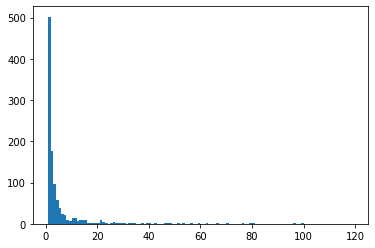

In [88]:
# most of mig rules only concluded from 1 mig
data = rules[rules.fromLibCategory == rules.toLibCategory].numRepositories
plt.hist(data, bins=range(min(data), max(data), 1))

In [108]:
TRIM_LESS_THAN = 10 # trimming mig rules with numRepo < TRIM_LESS_THAN
rules_filtered = rules[(rules.fromLibCategory == rules.toLibCategory) & (rules.numRepositories >= TRIM_LESS_THAN)]

# ref: https://stackoverflow.com/questions/59554213
rules_dict = {i: group.reset_index(drop=True) for i, group in rules_filtered.groupby('fromLibCategory')}
rules_dict['JSON']

,fromLib,toLib,fromLibCategory,toLibCategory,numRepositories,repos
0,com.google.code.gson:gson,com.fasterxml.jackson.core:jackson-databind,JSON,JSON,15,"{fcrepo4_fcrepo4, apache_qpid-broker-j, Graylo..."
1,org.codehaus.jackson:jackson-core-asl,com.fasterxml.jackson.core:jackson-annotations,JSON,JSON,47,"{Governance_rtgov, twitter_ambrose, campaignmo..."
2,org.codehaus.jackson:jackson-core-asl,com.fasterxml.jackson.core:jackson-core,JSON,JSON,66,"{apache_qpid-broker-j, Governance_rtgov, HalBu..."
3,org.codehaus.jackson:jackson-core-asl,com.fasterxml.jackson.core:jackson-databind,JSON,JSON,80,"{Jasig_uPortal, campaignmonitor_createsend-jav..."
4,org.codehaus.jackson:jackson-core-asl,com.fasterxml.jackson.jaxrs:jackson-jaxrs-json...,JSON,JSON,21,"{campaignmonitor_createsend-java, opendaylight..."
5,org.codehaus.jackson:jackson-core-asl,com.fasterxml.jackson.module:jackson-module-ja...,JSON,JSON,14,"{Intel-bigdata_SSM, apache_usergrid, apache_ha..."
6,org.codehaus.jackson:jackson-jaxrs,com.fasterxml.jackson.core:jackson-annotations,JSON,JSON,19,"{campaignmonitor_createsend-java, apache_brook..."
7,org.codehaus.jackson:jackson-jaxrs,com.fasterxml.jackson.core:jackson-core,JSON,JSON,21,"{opendaylight_controller, rackerlabs_atlas-lb,..."
8,org.codehaus.jackson:jackson-jaxrs,com.fasterxml.jackson.core:jackson-databind,JSON,JSON,26,"{campaignmonitor_createsend-java, opendaylight..."
9,org.codehaus.jackson:jackson-jaxrs,com.fasterxml.jackson.jaxrs:jackson-jaxrs-json...,JSON,JSON,29,"{apache_rave, LibrePlan_libreplan, campaignmon..."


In [109]:
# Write the graph as JSON
# refactor with get_migration_graph

TRIM_LESS_THAN = 0  # trimming mig rules with numRepo < TRIM_LESS_THAN

mig_graph_json = {'popthreshold': TRIM_LESS_THAN}

for cat, r in rules_dict.items():
    g = get_migration_graph(r, rename="all", popthreshold=TRIM_LESS_THAN)
    j = {"nodes": [], "edges": []}
    for n in g.nodes():
        ind = g.in_degree(n, "weight")
        outd = g.out_degree(n, "weight")
        flow = (ind - outd) / max(1, ind + outd)
        j["nodes"].append({"id": n, "flow": flow})
    for e in g.edges():
        j["edges"].append({"source": e[0], "target": e[1], "value": g.edges[e]["weight"]})
    mig_graph_json[cat] = j
# save it in cache
with open("cache/mig_graph.json", "w+") as f:
    json.dump(mig_graph_json, f)

In [110]:
try:
    mig_graph_json
except NameError:
    with open("cache/mig_graph.json", 'r') as f:
        mig_graph_json = json.load(f)

def list_to_plotly_nodes(nodes_list: list):
    res = {}
    res['label'] = [x['id'] for x in nodes_list]
    return res
    
def list_to_plotly_edges(edges_list: list):
    res = {}
    res['source'] = [x['source'] for x in edges_list]
    res['target'] = [x['target'] for x in edges_list]
    res['value'] = [x['value'] for x in edges_list]
    return res

list_to_plotly_nodes(mig_graph_json['JSON']['nodes'])
# list_to_plotly_edges(mig_graph_json['JSON']['edges'])

{'label': ['com.google.code.gson:gson',
  'com.fasterxml.jackson.core:jackson-databind',
  'org.codehaus.jackson:jackson-core-asl',
  'com.fasterxml.jackson.core:jackson-annotations',
  'com.fasterxml.jackson.core:jackson-core',
  'com.fasterxml.jackson.jaxrs:jackson-jaxrs-json-provider',
  'com.fasterxml.jackson.module:jackson-module-jaxb-annotations',
  'org.codehaus.jackson:jackson-jaxrs',
  'org.codehaus.jackson:jackson-mapper-asl',
  'org.codehaus.jackson:jackson-xc',
  'org.json:json']}

In [112]:
# ref: https://plotly.com/python/getting-started/#jupyterlab-support-python-35
# !pip install plotly 'ipywidgets>=7.5' # install plotly

import plotly.graph_objects as go
import plotly.io as pio
# # make sure plotly is working
# fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
# fig.show()

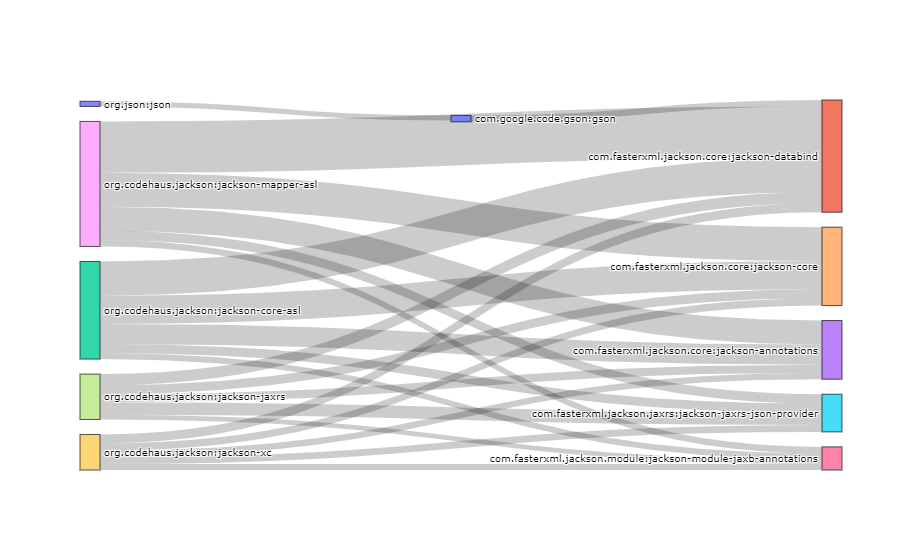

In [113]:
def plot_sankey(rules_json, width=600, height=550, is_log=False):
    labels = [x['id'] for x in rules_json['nodes']]
    flows = [x['flow'] for x in rules_json['nodes']]
    label_id = {node['id']: rules_json['nodes'].index(node) for node in rules_json['nodes']}
    sources = [label_id[x['source']] for x in rules_json['edges']]  # indices
    targets = [label_id[x['target']] for x in rules_json['edges']]
    values = [x['value'] for x in rules_json['edges']]
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels,
        ),
        link = dict(
          source = sources,
          target = targets,
          value = values
        ),
        arrangement="freeform"
    )])
    fig.update_layout(font_size=10, width=width, height=height)
    return fig

fig = plot_sankey(mig_graph_json['JSON'])
config = {
  'toImageButtonOptions': {
    'format': 'svg', # one of png, svg, jpeg, webp
    #'filename': 'custom_image',
    #'height': 500,
    #'width': 700,
    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.show(config=config)

In [61]:
import plotly.io as pio
pio.orca.config.use_xvfb = True
fig.write_image("plots/json.svg")
fig.write_image("plots/json.pdf")

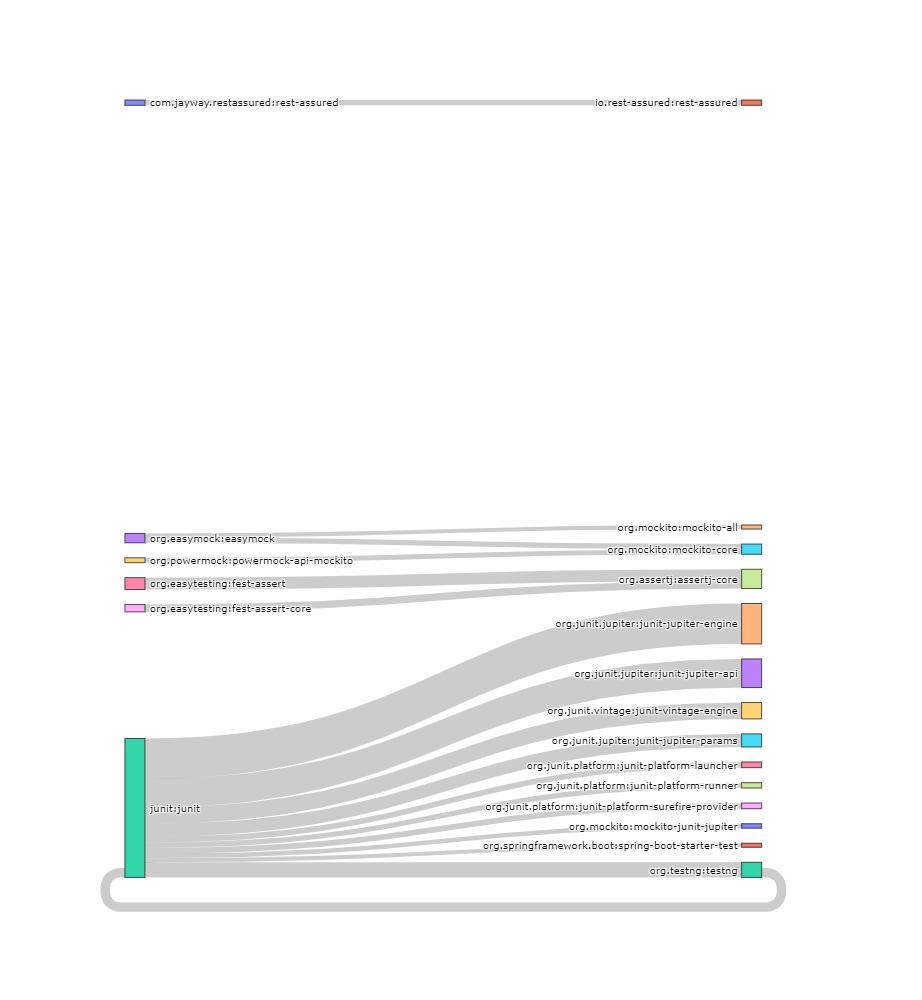

In [114]:
fig = plot_sankey(mig_graph_json['Testing'], width=700, height=1000)
config = {
  'toImageButtonOptions': {
    'format': 'svg', # one of png, svg, jpeg, webp
    #'filename': 'custom_image',
    #'height': 500,
    #'width': 700,
    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig.show(config=config)

In [63]:
fig.write_image("plots/testing.svg")
fig.write_image("plots/testing.pdf")

['ch.qos.logback:logback-classic', 'org.apache.logging.log4j:log4j-core', 'org.apache.logging.log4j:log4j-slf4j-impl', 'commons-logging:commons-logging', 'org.slf4j:jcl-over-slf4j', 'org.slf4j:slf4j-api', 'org.slf4j:slf4j-log4j12', 'log4j:log4j', 'org.apache.logging.log4j:log4j-api', 'org.slf4j:log4j-over-slf4j', 'ch.qos.logback:logback-core', 'org.slf4j:slf4j-simple']


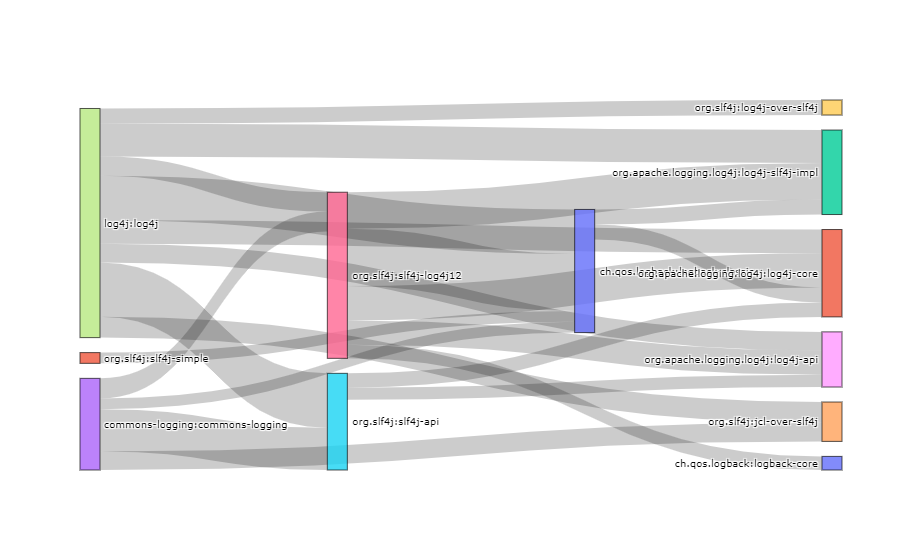

In [106]:
def plot_sankey(rules_json, width=600, height=550,is_log=False):
    labels = [x['id'] for x in rules_json['nodes']]
    print(labels)
    flows = [x['flow'] for x in rules_json['nodes']]
    label_id = {node['id']: rules_json['nodes'].index(node) for node in rules_json['nodes']}
    sources = [label_id[x['source']] for x in rules_json['edges']]  # indices
    targets = [label_id[x['target']] for x in rules_json['edges']]
    values = [x['value'] for x in rules_json['edges']]
    fig = go.Figure(data=[go.Sankey(
        node = dict(
          pad = 15,
          thickness = 20,
          line = dict(color = "black", width = 0.5),
          label = labels,
        ),
        link = dict(
          source = sources,
          target = targets,
          value = values
        ),
        arrangement="freeform"
    )])
    fig.update_layout(font_size=10, width=width, height=height)
    return fig

config = {
  'toImageButtonOptions': {
    'format': 'svg', # one of png, svg, jpeg, webp
    #'filename': 'custom_image',
    #'height': 500,
    #'width': 700,
    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
  }
}
fig = plot_sankey(mig_graph_json['Logging'])
fig.show(config=config)